# Student-t noise inference example

The Student-t distribution is a more robust distribution than the normal and, in some circumstances, can better represent the unmodelled part of the system.

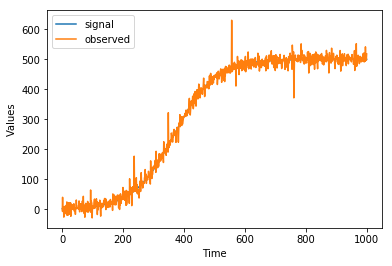

In [5]:
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
signal_values = model.simulate(real_parameters, times)

# Add Student-t noise
nu = 3
sigma = 10
observed_values = signal_values + scipy.stats.t.rvs(df=nu, loc=0, scale=sigma, size=signal_values.shape)
real_parameters = np.array(real_parameters + [nu, sigma])

# Plot
plt.plot(times,signal_values,label = 'signal')
plt.plot(times,observed_values,label = 'observed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

In [ ]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, observed_values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.StudentTLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, 0, sigma*0.1],
    [0.02, 600, nu*10, sigma*100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.0,
]

# Create mcmc routine
mcmc = pints.MCMCSampling(log_posterior, 3, xs, method=pints.AdaptiveCovarianceMCMC)

# Add stopping criterion
mcmc.set_max_iterations(16000)

# Start adapting after 1000 iterations
mcmc.set_adaptation_free_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 8000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True, ref_parameters=real_parameters)

# Show graphs
plt.show()

Running...
